In [1]:
import wandb
import pandas as pd
from loguru import logger
import torch
import torch.nn.functional as F
from datetime import datetime as dt
import os
from dateutil.relativedelta import relativedelta  # type: ignore
import functools
import json


from process_data import *
from constants import *
from model import *
from evaluate import *

In [2]:


start_date = dt.strptime("2021-10-24", "%Y-%m-%d").date()
if start_date == dt.strptime(MAX_START_DATE, "%Y-%m-%d").date():
    raise Exception("Stop Simulation")
end_date, nxt_start_date = split_date_by_period_months(start_date, TOTAL_MONTHS_PER_ITERATION)
print(start_date, end_date)
directory = directory = "/Users/yhchan/Downloads/FYP/data/processed"
reviews = pd.read_parquet(f"{directory}/reviews_with_interactions.parquet")
listings = pd.read_parquet(f"{directory}/listings_with_interactions.parquet")

config = {
        "architecture": "Unsupervised GraphSAGE",
        "start_date": start_date,
        "end_date": end_date,
        "learning_rate": 0.01,
        "hidden_channels": 64,
        "train_batch_size": 128,
        "test_batch_size": 128,
        "epochs": 50,
        "train_num_neighbours": [10, 10],
        "test_num_neighbours": [-1],
        "train_split_period_months": 10,
        "total_months_of_data": TOTAL_MONTHS_PER_ITERATION,
        "rec_K":1

    }

# Split into train, test and test for cold start scenario
(
    train_reviews,
    train_listings,
    train_reviewers,
    test_reviews,
    test_listings,
    test_reviewers,
) = main_train_test(
    reviews,
    listings,
    start_date,
    end_date,
    config["train_split_period_months"],
)

cold_start_test_reviews = filter_test_data_by_scenario(
    train_reviews, test_reviews, "reviewer_id", "cold_start_new_user"
)
cold_start_test_listings, cold_start_test_reviewers = build_partitioned_data(
    cold_start_test_reviews, listings
)
# Build Graph
involved_reviews = pd.concat([train_reviews, test_reviews])
involved_listings, involved_reviewers = build_partitioned_data(involved_reviews, listings)
involved_data = build_heterograph(involved_reviews, involved_listings, involved_reviewers, True)
train_data = build_heterograph(train_reviews, train_listings, train_reviewers, True)
test_data = build_heterograph(test_reviews, test_listings, test_reviewers, True)
cold_start_test_data = build_heterograph(cold_start_test_reviews, cold_start_test_listings, cold_start_test_reviewers, True)
print("Whole Graph", involved_data)
print("Training Heterogenous Graph", train_data)
print("Test Heterogenous Graph", test_data)
print("Test Heterogenous Graph (Cold Start Scenerio)", cold_start_test_data)

involved_listings2dict = get_entity2dict(involved_listings, "listing_id")
reverse_involved_listings2dict = {k: v for v, k in involved_listings2dict.items()}

2021-10-24 2022-10-23


2023-04-29 17:49:29.036 | INFO     | process_data:main_train_test:140 - Split df into train and test portion
/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/process_data.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525682339/work/torch/csrc/utils/tensor_numpy.cpp:205.)
  temp = torch.from_numpy(val).view(-1, 1).to(torch.float32)


Whole Graph HeteroData(
  listing={ x=[18523, 158] },
  user={ x=[394551, 384] },
  (user, rates, listing)={
    edge_index=[2, 408596],
    edge_label=[408596],
    edge_label_index=[2, 408596]
  },
  (listing, rev_rates, user)={ edge_index=[2, 408596] }
)
Training Heterogenous Graph HeteroData(
  listing={ x=[17229, 158] },
  user={ x=[324135, 384] },
  (user, rates, listing)={
    edge_index=[2, 334678],
    edge_label=[334678],
    edge_label_index=[2, 334678]
  },
  (listing, rev_rates, user)={ edge_index=[2, 334678] }
)
Test Heterogenous Graph HeteroData(
  listing={ x=[14380, 158] },
  user={ x=[72447, 384] },
  (user, rates, listing)={
    edge_index=[2, 73918],
    edge_label=[73918],
    edge_label_index=[2, 73918]
  },
  (listing, rev_rates, user)={ edge_index=[2, 73918] }
)
Test Heterogenous Graph (Cold Start Scenerio) HeteroData(
  listing={ x=[14254, 158] },
  user={ x=[70416, 384] },
  (user, rates, listing)={
    edge_index=[2, 71775],
    edge_label=[71775],
    edge_l

In [3]:
display(test_reviews.info())
display(cold_start_test_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73918 entries, 0 to 1442686
Columns: 405 entries, listing_id to comment_embedding_383
dtypes: bool(2), datetime64[ns, UTC](1), float64(384), int64(2), object(16)
memory usage: 228.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71775 entries, 0 to 1442686
Columns: 405 entries, listing_id to comment_embedding_383
dtypes: bool(2), datetime64[ns, UTC](1), float64(384), int64(2), object(16)
memory usage: 221.4+ MB


None

In [4]:
path_prefix = './best_models'
K = config["rec_K"]
best_rating_weighted_model_path = f"{path_prefix}/rating_weighted_graphsage_state_dict.pt"
best_rating_weighted_model = load_model(best_rating_weighted_model_path, config["hidden_channels"], involved_data)

## Compare the result with different values of n_clusters across different K

In [1]:
import json

def write_dict_into_json(dictionary, filename):
    with open(filename, "w") as write_file:
        json.dump(dictionary, write_file, indent=4)

In [6]:
# Generate embedding for all users and listings with semi personalization\



## Compare across n_cluster
K = 5
n_cluster_list = [5,10,100,1000]
result_dict = {}
# Without semi personalization
u2i_hit_rate, u2i_coverage, i2i_hit_rate, i2i_coverage = run_eval(
    involved_data,
    involved_reviewers,
    involved_listings2dict,
    reverse_involved_listings2dict,
    cold_start_test_reviews,
    cold_start_test_reviewers,
    K,
    best_rating_weighted_model
)
wo_semi_perso = [u2i_hit_rate, u2i_coverage, i2i_hit_rate, i2i_coverage]
for n_clusters in n_cluster_list:
    # With semi personalization
    u2i_hit_rate_semi_perso, u2i_coverage_semi_perso, i2i_hit_rate_semi_perso, i2i_coverage_semi_perso = run_eval_with_semi_personalization(
        involved_data,
        involved_reviewers,
        involved_listings2dict,
        reverse_involved_listings2dict,
        cold_start_test_reviews,
        cold_start_test_reviewers,
        K,
        n_clusters,
        best_rating_weighted_model
    )
    metrics_dict = {
        "wo_semi_perso": wo_semi_perso,
        "w_semi_perso" : [u2i_hit_rate_semi_perso, u2i_coverage_semi_perso, i2i_hit_rate_semi_perso, i2i_coverage_semi_perso]
    }
    result_dict[f"{n_clusters}"] = metrics_dict


write_dict_into_json(result_dict, "cold_start_eval.json")


K = 5
Start generating embeddings
Finish generating embeddings
Start u2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 70416, Length of ground truth: 70416
Count of hit & non-hit:  Counter({1: 70414, 0: 2})
n_unique_recommendations:  18128
n_available_listings:  18523
u2i hit rate:  0.9999715973642354
u2i coverage:  0.9786751606111321
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1258, Length of ground truth: 1258
Count of hit & non-hit:  Counter({0: 1185, 1: 73})
n_unique_recommendations:  4510
n_available_listings:  18523
i2i hit rate:  0.05802861685214626
i2i coverage:  0.24348107757922582
Start generating embeddings
Finish generating embeddings
Running K-Means Algorithm...


/Users/yhchan/miniconda3/envs/tt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete running K-Means Algorithm...
cold_start_test_reviewer_indices [322104 322105 322106 ... 394547 394548 394550]
i 322104
i 322105
i 322106
i 322107
i 322108
i 322109
i 322110
i 322113
i 322114
i 322115
i 322116
i 322117
i 322118
i 322119
i 322120
i 322121
i 322122
i 322123
i 322124
i 322125
i 322126
i 322127
i 322128
i 322129
i 322130
i 322131
i 322132
i 322133
i 322134
i 322135
i 322136
i 322137
i 322138
i 322139
i 322140
i 322141
i 322142
i 322143
i 322144
i 322145
i 322146
i 322147
i 322148
i 322149
i 322150
i 322151
i 322152
i 322153
i 322154
i 322155
i 322156
i 322157
i 322158
i 322159
i 322160
i 322161
i 322162
i 322163
i 322164
i 322165
i 322166
i 322167
i 322168
i 322169
i 322170
i 322171
i 322172
i 322173
i 322174
i 322175
i 322177
i 322178
i 322180
i 322181
i 322182
i 322183
i 322184
i 322185
i 322186
i 322187
i 322189
i 322190
i 322191
i 322192
i 322193
i 322194
i 322195
i 322196
i 322197
i 322198
i 322199
i 322200
i 322201
i 322202
i 322203
i 322204
i 322205
i 322206

i 390973
i 390974
i 390975
i 390976
i 390977
i 390978
i 390979
i 390980
i 390981
i 390982
i 390983
i 390984
i 390985
i 390986
i 390987
i 390988
i 390989
i 390990
i 390991
i 390992
i 390993
i 390994
i 390995
i 390996
i 390997
i 390998
i 390999
i 391000
i 391001
i 391002
i 391003
i 391004
i 391005
i 391006
i 391007
i 391008
i 391009
i 391010
i 391011
i 391012
i 391013
i 391014
i 391015
i 391016
i 391017
i 391018
i 391019
i 391020
i 391021
i 391022
i 391023
i 391024
i 391025
i 391026
i 391027
i 391028
i 391029
i 391030
i 391031
i 391032
i 391033
i 391034
i 391035
i 391036
i 391037
i 391038
i 391039
i 391040
i 391041
i 391042
i 391043
i 391044
i 391045
i 391046
i 391047
i 391048
i 391049
i 391050
i 391051
i 391052
i 391053
i 391054
i 391055
i 391056
i 391057
i 391058
i 391059
i 391060
i 391061
i 391062
i 391063
i 391064
i 391065
i 391066
i 391067
i 391068
i 391069
i 391070
i 391071
i 391072
i 391073
i 391074
i 391075
i 391076
i 391077
i 391078
i 391079
i 391080
i 391081
i 391082
i 391083
i

/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 70416, Length of ground truth: 70416
Count of hit & non-hit:  Counter({0: 70295, 1: 121})
n_unique_recommendations:  25
n_available_listings:  18523
u2i hit rate:  0.0017183594637582367
u2i coverage:  0.0013496733790422718
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1258, Length of ground truth: 1258
Count of hit & non-hit:  Counter({0: 1185, 1: 73})
n_unique_recommendations:  4510
n_available_listings:  18523
i2i hit rate:  0.05802861685214626
i2i coverage:  0.24348107757922582
Start generating embeddings
Finish generating embeddings
Running K-Means Algorithm...


/Users/yhchan/miniconda3/envs/tt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete running K-Means Algorithm...
cold_start_test_reviewer_indices [322104 322105 322106 ... 394547 394548 394550]
i 322104
i 322105
i 322106
i 322107
i 322108
i 322109
i 322110
i 322113
i 322114
i 322115
i 322116
i 322117
i 322118
i 322119
i 322120
i 322121
i 322122
i 322123
i 322124
i 322125
i 322126
i 322127
i 322128
i 322129
i 322130
i 322131
i 322132
i 322133
i 322134
i 322135
i 322136
i 322137
i 322138
i 322139
i 322140
i 322141
i 322142
i 322143
i 322144
i 322145
i 322146
i 322147
i 322148
i 322149
i 322150
i 322151
i 322152
i 322153
i 322154
i 322155
i 322156
i 322157
i 322158
i 322159
i 322160
i 322161
i 322162
i 322163
i 322164
i 322165
i 322166
i 322167
i 322168
i 322169
i 322170
i 322171
i 322172
i 322173
i 322174
i 322175
i 322177
i 322178
i 322180
i 322181
i 322182
i 322183
i 322184
i 322185
i 322186
i 322187
i 322189
i 322190
i 322191
i 322192
i 322193
i 322194
i 322195
i 322196
i 322197
i 322198
i 322199
i 322200
i 322201
i 322202
i 322203
i 322204
i 322205
i 322206

Start u2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 70416, Length of ground truth: 70416
Count of hit & non-hit:  Counter({0: 70210, 1: 206})
n_unique_recommendations:  47
n_available_listings:  18523
u2i hit rate:  0.0029254714837536923
u2i coverage:  0.0025373859525994707
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1258, Length of ground truth: 1258
Count of hit & non-hit:  Counter({0: 1185, 1: 73})
n_unique_recommendations:  4510
n_available_listings:  18523
i2i hit rate:  0.05802861685214626
i2i coverage:  0.24348107757922582
Start generating embeddings
Finish generating embeddings
Running K-Means Algorithm...


/Users/yhchan/miniconda3/envs/tt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete running K-Means Algorithm...
cold_start_test_reviewer_indices [322104 322105 322106 ... 394547 394548 394550]
i 322104
i 322105
i 322106
i 322107
i 322108
i 322109
i 322110
i 322113
i 322114
i 322115
i 322116
i 322117
i 322118
i 322119
i 322120
i 322121
i 322122
i 322123
i 322124
i 322125
i 322126
i 322127
i 322128
i 322129
i 322130
i 322131
i 322132
i 322133
i 322134
i 322135
i 322136
i 322137
i 322138
i 322139
i 322140
i 322141
i 322142
i 322143
i 322144
i 322145
i 322146
i 322147
i 322148
i 322149
i 322150
i 322151
i 322152
i 322153
i 322154
i 322155
i 322156
i 322157
i 322158
i 322159
i 322160
i 322161
i 322162
i 322163
i 322164
i 322165
i 322166
i 322167
i 322168
i 322169
i 322170
i 322171
i 322172
i 322173
i 322174
i 322175
i 322177
i 322178
i 322180
i 322181
i 322182
i 322183
i 322184
i 322185
i 322186
i 322187
i 322189
i 322190
i 322191
i 322192
i 322193
i 322194
i 322195
i 322196
i 322197
i 322198
i 322199
i 322200
i 322201
i 322202
i 322203
i 322204
i 322205
i 322206

Start u2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 70416, Length of ground truth: 70416
Count of hit & non-hit:  Counter({0: 65803, 1: 4613})
n_unique_recommendations:  490
n_available_listings:  18523
u2i hit rate:  0.06551067939104749
u2i coverage:  0.026453598229228527
Start i2i recommendation


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 1258, Length of ground truth: 1258
Count of hit & non-hit:  Counter({0: 1185, 1: 73})
n_unique_recommendations:  4510
n_available_listings:  18523
i2i hit rate:  0.05802861685214626
i2i coverage:  0.24348107757922582
Start generating embeddings
Finish generating embeddings
Running K-Means Algorithm...


/Users/yhchan/miniconda3/envs/tt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete running K-Means Algorithm...
cold_start_test_reviewer_indices [322104 322105 322106 ... 394547 394548 394550]
i 322104
i 322105
i 322106
i 322107
i 322108
i 322109
i 322110
i 322113
i 322114
i 322115
i 322116
i 322117
i 322118
i 322119
i 322120
i 322121
i 322122
i 322123
i 322124
i 322125
i 322126
i 322127
i 322128
i 322129
i 322130
i 322131
i 322132
i 322133
i 322134
i 322135
i 322136
i 322137
i 322138
i 322139
i 322140
i 322141
i 322142
i 322143
i 322144
i 322145
i 322146
i 322147
i 322148
i 322149
i 322150
i 322151
i 322152
i 322153
i 322154
i 322155
i 322156
i 322157
i 322158
i 322159
i 322160
i 322161
i 322162
i 322163
i 322164
i 322165
i 322166
i 322167
i 322168
i 322169
i 322170
i 322171
i 322172
i 322173
i 322174
i 322175
i 322177
i 322178
i 322180
i 322181
i 322182
i 322183
i 322184
i 322185
i 322186
i 322187
i 322189
i 322190
i 322191
i 322192
i 322193
i 322194
i 322195
i 322196
i 322197
i 322198
i 322199
i 322200
i 322201
i 322202
i 322203
i 322204
i 322205
i 322206

i 380399
i 380400
i 380401
i 380402
i 380403
i 380404
i 380405
i 380406
i 380407
i 380408
i 380410
i 380411
i 380412
i 380413
i 380414
i 380415
i 380416
i 380417
i 380418
i 380419
i 380420
i 380421
i 380422
i 380423
i 380424
i 380425
i 380426
i 380427
i 380428
i 380429
i 380430
i 380431
i 380432
i 380433
i 380434
i 380435
i 380436
i 380437
i 380438
i 380439
i 380440
i 380441
i 380442
i 380443
i 380444
i 380445
i 380446
i 380447
i 380449
i 380450
i 380451
i 380452
i 380453
i 380454
i 380455
i 380456
i 380457
i 380458
i 380459
i 380460
i 380462
i 380463
i 380464
i 380465
i 380466
i 380467
i 380468
i 380469
i 380470
i 380471
i 380472
i 380473
i 380474
i 380475
i 380476
i 380477
i 380478
i 380479
i 380480
i 380481
i 380482
i 380483
i 380484
i 380485
i 380486
i 380487
i 380488
i 380489
i 380491
i 380493
i 380494
i 380495
i 380496
i 380497
i 380498
i 380499
i 380500
i 380501
i 380502
i 380503
i 380504
i 380505
i 380506
i 380507
i 380508
i 380509
i 380510
i 380511
i 380512
i 380513
i 380514
i

/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


Length of recommendations: 70416, Length of ground truth: 70416
Count of hit & non-hit:  Counter({0: 42578, 1: 27838})
n_unique_recommendations:  4376
n_available_listings:  18523
u2i hit rate:  0.39533628720745284
u2i coverage:  0.23624682826755924
Start i2i recommendation
Length of recommendations: 1258, Length of ground truth: 1258
Count of hit & non-hit:  Counter({0: 1185, 1: 73})
n_unique_recommendations:  4510
n_available_listings:  18523
i2i hit rate:  0.05802861685214626
i2i coverage:  0.24348107757922582


/Users/yhchan/Downloads/FYP/CT_Recsys/modelling/graphsage/evaluate.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(recommendations), np.array(ground_truths)


In [3]:
f = open(f"eval_result/cold_start_eval.json")
cold_start_eval = json.load(f)
cold_start_eval

{'5': {'wo_semi_perso': [0.9999715973642354,
   0.9786751606111321,
   0.05802861685214626,
   0.24348107757922582],
  'w_semi_perso': [0.0017183594637582367,
   0.0013496733790422718,
   0.05802861685214626,
   0.24348107757922582]},
 '10': {'wo_semi_perso': [0.9999715973642354,
   0.9786751606111321,
   0.05802861685214626,
   0.24348107757922582],
  'w_semi_perso': [0.0029254714837536923,
   0.0025373859525994707,
   0.05802861685214626,
   0.24348107757922582]},
 '100': {'wo_semi_perso': [0.9999715973642354,
   0.9786751606111321,
   0.05802861685214626,
   0.24348107757922582],
  'w_semi_perso': [0.06551067939104749,
   0.026453598229228527,
   0.05802861685214626,
   0.24348107757922582]},
 '1000': {'wo_semi_perso': [0.9999715973642354,
   0.9786751606111321,
   0.05802861685214626,
   0.24348107757922582],
  'w_semi_perso': [0.39533628720745284,
   0.23624682826755924,
   0.05802861685214626,
   0.24348107757922582]}}

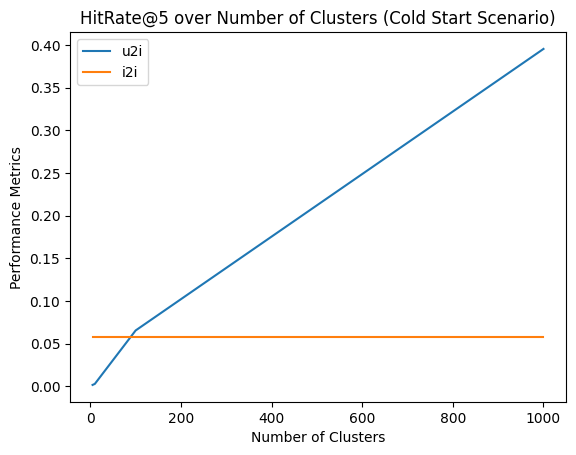

In [5]:
# Hit rate@5 over number of cluster

import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = [5, 10, 100, 1000]
u2i_hit_rate_5 = []
i2i_hit_rate_5 = []
for i in x:
    metrics = cold_start_eval[str(i)]['w_semi_perso']
    u2i_hit_rate_5.append(metrics[0])
    i2i_hit_rate_5.append(metrics[2])

hit_rate_dict = {
    "u2i":u2i_hit_rate_5,
    "i2i":i2i_hit_rate_5
}
fig, ax = plt.subplots()

# Plot the performance metrics for each model
xticks = [1,3,5,10]
for label, metric_values in hit_rate_dict.items():
    ax.plot(x, metric_values, label=label)

# Set the x-axis label and tick values
ax.set_xlabel('Number of Clusters')

# Set the y-axis label and limits
ax.set_ylabel('Performance Metrics')

# Set the chart title
plt.title('HitRate@5 over Number of Clusters (Cold Start Scenario)')

# Add a legend to the chart
ax.legend()


# Show the plot
plt.show()

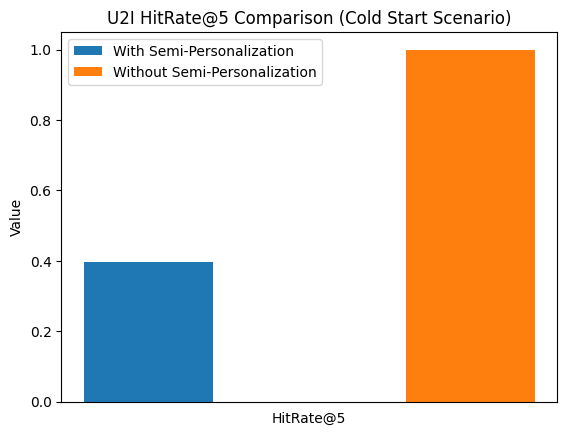

In [11]:
# Barchart for hitrate@5 using u2i recommendation in cold start scenario
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
w_semi_perso_u2i_hitrate = cold_start_eval["1000"]['w_semi_perso'][0]
wo_semi_perso_u2i_hitrate = cold_start_eval["1000"]['wo_semi_perso'][0]

# Set the positions of the bars on the x-axis
r1 = np.arange(1)
r2 = [x + 0.25 for x in r1]

width = 0.1

# Plot the bar chart
plt.bar(r1, w_semi_perso_u2i_hitrate, width=width, label='With Semi-Personalization')
plt.bar(r2, wo_semi_perso_u2i_hitrate, width=width, label='Without Semi-Personalization')

# Add xticks on the middle of the group bars
plt.xticks([])

# Add labels and title
plt.xlabel('HitRate@5')
plt.ylabel('Value')
plt.title('U2I HitRate@5 Comparison (Cold Start Scenario)')
plt.legend()

# Show the plot
plt.show()

In [12]:
print('w_semi_perso_u2i_hitrate', w_semi_perso_u2i_hitrate)
print('wo_semi_perso_u2i_hitrate', wo_semi_perso_u2i_hitrate)

w_semi_perso_u2i_hitrate 0.39533628720745284
wo_semi_perso_u2i_hitrate 0.9999715973642354
